Importing the required packages.

If you need to install new packages, use !pip install Package_name

In [1]:
!pip install pyreadr

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pyreadr
from google.colab import files
import copy
from scipy.optimize import fmin_slsqp
from sklearn.metrics import mean_squared_error


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.2/776.2 kB 31.6 MB/s eta 0:00:00


Importing data.

In [4]:
#Uploading file to Google Colab.
#uploaded = files.upload()

In [19]:
import requests
url = "https://raw.githubusercontent.com/clarkian-teachings/data5k/main/week_05/prop99.csv"

df_outcome_raw = pd.read_csv(url)
df_outcome_raw.head()

,LocationAbbr,LocationDesc,Year,Datasource,TopicDesc,MeasureDesc,SubMeasureDesc,Data_Value,Data_Value_Unit,Data_Value_Type,GeoLocation,Source,TopicTypeId,TopicId,MeasureId,SubMeasureID,SubMeasureIdDisplayOrder
0,AL,Alabama,2014,OW,The Tax Burden on Tobacco,Cigarette Sales,Average Cost per pack,5.102000e+00,$,Dollars,"(32.84057112200048, -86.63186076199969)","Table 13- Orzechowski and Walker, Tax Burden o...",POL,450POL,450CGS,455CGS,1
1,AL,Alabama,2014,OW,The Tax Burden on Tobacco,Cigarette Sales,Cigarette Consumption (Pack Sales Per Capita),6.170000e+01,NaN,Pack,"(32.84057112200048, -86.63186076199969)","Table 11- Orzechowski and Walker, Tax Burden o...",POL,450POL,450CGS,453CGS,2
2,AL,Alabama,2014,OW,The Tax Burden on Tobacco,Cigarette Sales,Federal and State tax as a Percentage of Retai...,2.810000e+01,%,Percentage,"(32.84057112200048, -86.63186076199969)","Table 13- Orzechowski and Walker, Tax Burden o...",POL,450POL,450CGS,454CGS,3
3,AL,Alabama,2014,OW,The Tax Burden on Tobacco,Cigarette Sales,Federal and State Tax per pack,1.435000e+00,$,Dollars,"(32.84057112200048, -86.63186076199969)","Table 13- Orzechowski and Walker, Tax Burden o...",POL,450POL,450CGS,452CGS,4
4,AL,Alabama,2014,OW,The Tax Burden on Tobacco,Cigarette Sales,Gross Cigarette Tax Revenue,1.268532e+08,$,Dollars,"(32.84057112200048, -86.63186076199969)","Table 12- Orzechowski and Walker, Tax Burden o...",POL,450POL,450CGS,456CGS,5


In [22]:
import requests
import pyreadr

# Step 1: download the file
url_rda = "https://raw.githubusercontent.com/clarkian-teachings/data5k/main/week_05/smoking.rda"
r = requests.get(url_rda)

with open("smoking.rda", "wb") as f:
    f.write(r.content)

rda_predictors = pyreadr.read_r("smoking.rda")

Data pre-processing.

In [23]:
# Only including observations where SubMeasureDesc = 'Cigarette Consumption (Pack Sales Per Capita)'.
df_outcome_raw = df_outcome_raw[df_outcome_raw['SubMeasureDesc'] == 'Cigarette Consumption (Pack Sales Per Capita)']

# Reformatting data into panel data form.
df_outcome = pd.DataFrame(df_outcome_raw.pivot_table(values='Data_Value', index='LocationDesc', columns=['Year']).to_records())

# Extracting first data structure and formatting to Pandas dataframe.
df_predictors = pd.DataFrame(list(rda_predictors.values())[0])

Setting important reference dates.

In [24]:
START_TIME = 1970
INTERVENTION_TIME = 1989
STOP_TIME = 2001

Checking data

In [25]:
df_outcome.sample(10)

,LocationDesc,1970,1971,1972,1973,1974,1975,1976,1977,1978,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
48,West Virginia,114.5,111.5,117.5,116.6,119.9,123.2,129.7,133.9,131.6,...,102.4,112.2,110.5,112.8,115.8,113.0,107.9,105.0,103.1,97.4
31,New Mexico,90.0,92.6,99.3,98.9,100.3,103.1,102.4,102.4,103.1,...,35.5,35.4,34.6,34.0,32.7,30.3,27.3,26.7,26.4,24.6
9,Florida,123.6,123.0,126.0,132.6,136.0,131.9,130.3,133.1,133.4,...,75.3,71.9,69.9,67.9,70.6,50.0,49.7,45.9,44.3,42.4
12,Idaho,102.4,108.5,126.1,121.8,125.6,123.3,125.1,125.0,122.8,...,58.3,58.8,58.6,55.9,52.4,46.4,45.5,43.5,43.1,40.8
39,Rhode Island,123.9,123.2,134.4,142.0,146.1,154.7,150.2,148.8,146.8,...,49.4,47.3,45.3,43.6,44.7,37.1,36.3,35.8,35.3,36.7
7,Delaware,155.0,161.1,156.3,154.7,151.3,147.6,153.0,153.3,155.5,...,178.8,183.6,185.2,133.3,122.8,95.0,87.6,84.9,77.1,71.2
36,Oklahoma,108.4,115.4,121.7,124.1,130.5,132.9,138.6,140.4,143.6,...,98.2,87.2,85.8,86.7,79.0,71.2,71.0,71.3,67.2,64.3
29,New Hampshire,265.7,278.0,296.2,279.0,269.8,269.1,290.5,278.8,269.6,...,138.6,135.5,131.6,113.5,116.6,97.1,92.9,93.9,89.6,90.6
1,Alaska,121.3,123.0,130.0,125.8,130.4,150.4,164.8,159.3,143.6,...,60.2,54.5,52.9,47.0,45.8,43.8,43.3,41.2,39.0,37.2
45,Vermont,122.6,124.4,138.0,146.8,151.8,155.5,171.1,169.4,162.4,...,63.9,63.9,54.5,51.6,48.9,47.7,48.7,45.7,42.1,40.4


In [26]:
df_predictors.sample(10)

,state,year,cigsale,lnincome,beer,age15to24,retprice
174,6.0,1989.0,131.699997,10.103605,24.9,0.152689,124.000000
1053,34.0,2000.0,40.700001,NaN,NaN,NaN,312.899994
626,21.0,1976.0,201.399994,9.955231,NaN,0.174872,44.900002
539,18.0,1982.0,139.699997,9.802688,NaN,0.175406,64.699997
875,29.0,1977.0,148.800003,9.819708,NaN,0.187999,52.299999
866,28.0,1999.0,91.099998,NaN,NaN,NaN,205.000000
1207,39.0,1999.0,104.800003,NaN,NaN,NaN,189.600006
1034,34.0,1981.0,77.599998,9.640061,NaN,0.198395,62.700001
965,32.0,1974.0,114.800003,9.609496,NaN,0.181146,42.500000
300,10.0,1991.0,127.199997,9.921082,21.6,NaN,135.800003


Filtering for only states who did not implement any cigarette control measure between intervention time and stop time.

Massachusetts, Arizona, Oregon, and Florida introduced formal statewide tobacco control in 1989 - 2000.

Alaska, Hawaii, Maryland, Michigan, New Jersey, New York, Washington raised their state cigarette taxes by 50 cents or more in 1989 - 2000.

In [27]:
print(f'In the original dataset there are {df_outcome.LocationDesc.unique().shape[0]} states')

# Filtering out states who implemented cigarette control measures.
bad_states = ['Massachusetts', 'Arizona', 'Oregon', 'Florida', 'Alaska', 'Hawaii', 'Maryland',
              'Michigan', 'New Jersey', 'New York', 'Washington', 'District of Columbia']

df_outcome.drop(df_outcome[df_outcome['LocationDesc'].isin(bad_states)].index, inplace=True)
ca_id = df_outcome[df_outcome['LocationDesc'] == 'California'].index.item()
df_outcome = df_outcome.reset_index()
df_outcome = df_outcome.rename(columns={'index': 'org_index'})

print(f'After filtering out some states, we are left with {df_outcome.LocationDesc.unique().shape[0]} states (including California):')
df_outcome.head()

In the original dataset there are 51 states
After filtering out some states, we are left with 39 states (including California):


,org_index,LocationDesc,1970,1971,1972,1973,1974,1975,1976,1977,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,0,Alabama,89.8,95.4,101.1,102.9,108.2,111.7,116.2,117.1,...,82.4,83.3,80.2,78.0,75.6,71.5,68.4,67.2,64.6,61.7
1,3,Arkansas,100.3,104.1,103.9,108.0,109.7,114.8,119.1,122.6,...,82.1,81.4,78.4,77.0,72.6,63.2,61.1,60.5,57.5,54.4
2,4,California,123.0,121.0,123.5,124.4,126.7,127.1,128.0,126.4,...,33.1,32.9,31.8,30.3,28.8,26.3,26.0,25.2,23.9,22.7
3,5,Colorado,124.8,125.5,134.3,137.9,132.8,131.0,134.2,132.0,...,57.9,53.1,51.1,48.4,46.0,41.4,40.6,40.6,38.3,36.7
4,6,Connecticut,120.0,117.6,110.8,109.3,112.4,110.2,113.4,117.3,...,49.9,50.9,50.5,47.4,45.9,40.8,36.3,33.5,31.4,30.1


Creating dataframes for Synthetic Control Model (SCM).

In [28]:
# Creating dataframes for California and other states (control group).

df_outcome_ca = df_outcome.loc[df_outcome['LocationDesc'] == 'California', :]
df_outcome_control = df_outcome.loc[df_outcome['LocationDesc'] != 'California', :]

# Creating dataframes for before and after intervention.
ca_outcomes_pre = df_outcome_ca.loc[:,[str(i) for i in list(range(START_TIME, INTERVENTION_TIME))]].values.reshape(-1,1)
control_outcomes_pre = df_outcome_control.loc[:,[str(i) for i in list(range(START_TIME, INTERVENTION_TIME))]].values.transpose()

ca_outcomes_post = df_outcome_ca.loc[:,[str(i) for i in list(range(INTERVENTION_TIME, STOP_TIME))]].values.reshape(-1,1)
control_outcomes_post = df_outcome_control.loc[:,[str(i) for i in list(range(INTERVENTION_TIME, STOP_TIME))]].values.transpose()

Z0 = control_outcomes_pre
Z1 = ca_outcomes_pre
Y0 = control_outcomes_post
Y1 = ca_outcomes_post

Plotting timeseries for Cigarette sales in California and control group.

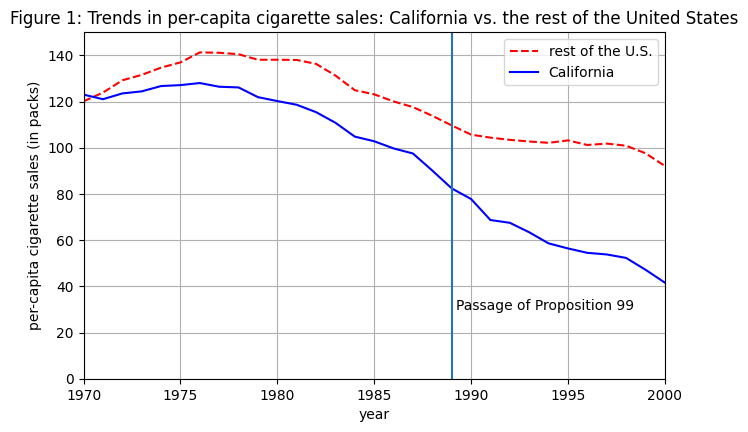

In [29]:
mean_outcomes = np.vstack([Z0, Y0]).mean(axis=1)
CA_outcomes = np.vstack([Z1, Y1]).flatten()
fig = plt.figure(figsize=(7.5,4.5))
plt.plot(range(START_TIME,STOP_TIME),mean_outcomes, 'r--', label="rest of the U.S.");
plt.plot(range(START_TIME,STOP_TIME),CA_outcomes, 'b-', label="California");

plt.ylabel('per-capita cigarette sales (in packs)')
plt.xlabel('year')
plt.legend(loc='upper right')
plt.title("Figure 1: Trends in per-capita cigarette sales: California vs. the rest of the United States")
plt.axvline(INTERVENTION_TIME)
plt.text(x=INTERVENTION_TIME+0.2, y=30, s='Passage of Proposition 99')
plt.xlim([START_TIME, STOP_TIME-1])
plt.ylim([0, 150])
plt.grid()
plt.show()
fig.savefig("name", dpi=300)

Extracting specific predictor values for cigarette sales from df_outcome_state for the years 1988, 1980, and 1975.

In [30]:
def extract_predictor_vec(state):
    df_outcome_state = df_outcome[df_outcome['LocationDesc'] == state]
    cigsale88_predictor = df_outcome_state['1988'].item()
    cigsale80_predictor = df_outcome_state['1980'].item()
    cigsale75_predictor = df_outcome_state['1975'].item()

# Calculating mean predictor values for beer, age15to24, retprice, and lnincome.
    state_id_predictors_df = df_outcome[df_outcome['LocationDesc'] == 'California'].index.item() + 1
    df_predictors_state = df_predictors[df_predictors['state'] == state_id_predictors_df]
    beer_predictor = df_predictors_state.loc[(df_predictors_state['year'] >= 1984) & (df_predictors_state['year'] < INTERVENTION_TIME), 'beer'].mean()
    age15to24_predictor = df_predictors_state.loc[(df_predictors_state['year'] >= 1980) & (df_predictors_state['year'] < INTERVENTION_TIME), 'age15to24'].mean()*100
    retprice_predictor = df_predictors_state.loc[(df_predictors_state['year'] >= 1980) & (df_predictors_state['year'] < INTERVENTION_TIME), 'retprice'].mean()
    lnincome_predictor = df_predictors_state.loc[(df_predictors_state['year'] >= 1980) & (df_predictors_state['year'] < INTERVENTION_TIME), 'lnincome'].mean()

    return np.array([lnincome_predictor, age15to24_predictor, retprice_predictor, beer_predictor,
                     cigsale88_predictor, cigsale80_predictor, cigsale75_predictor]).reshape(-1,1)

Extracting predictors for California and states in control group.

In [31]:
control_predictors = []
for state in df_outcome['LocationDesc'].unique():
    state_predictor_vec = extract_predictor_vec(state)
    if state == 'California':
        ca_predictors = state_predictor_vec
    else:
        control_predictors += [state_predictor_vec]

control_predictors = np.hstack(control_predictors)

X0 = control_predictors
X1 = ca_predictors

Finding the weights for the SCM.

In [32]:
# Function to calculate the weighted mean squared error between the predicted outcomes (x0.dot(w)) and the actual outcomes.
def w_mse(w, v, x0, x1): return mean_squared_error(x1, x0.dot(w), sample_weight=v)

# Setting constraints for weights (must be equal to 1).
def w_constraint(w, v, x0, x1): return np.sum(w) - 1

def v_constraint(V, W, X0, X1, Z0, Z1): return np.sum(V) - 1

# Function to minimise WMSE given constraints.
def fun_w(w, v, x0, x1): return fmin_slsqp(w_mse, w, bounds=[(0.0, 1.0)]*len(w), f_eqcons=w_constraint,
                                           args=(v, x0, x1), disp=False, full_output=True)[0]

# Calculating MSE to optimise weights.
def fun_v(v, w, x0, x1, z0, z1): return mean_squared_error(z1, z0.dot(fun_w(w, v, x0, x1)))

# Implementing SCM
def solve_synthetic_control(X0, X1, Z0, Z1, Y0):
    k,j = X0.shape
    V0 = 1/k*np.ones(k)
    W0 = 1/j*np.zeros(j).transpose()
    V = fmin_slsqp(fun_v, V0, args=(W0, X0, X1, Z0, Z1), bounds=[(0.0, 1.0)]*len(V0), disp=True, f_eqcons=v_constraint, acc=1e-6)
    W = fun_w(W0, V, X0, X1)
    return V, W

V, W = solve_synthetic_control(X0, X1, Z0, Z1, Y0)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 23.401515266507246
            Iterations: 5
            Function evaluations: 8
            Gradient evaluations: 1


Plotting California versus Synthetic control cigarette sales.

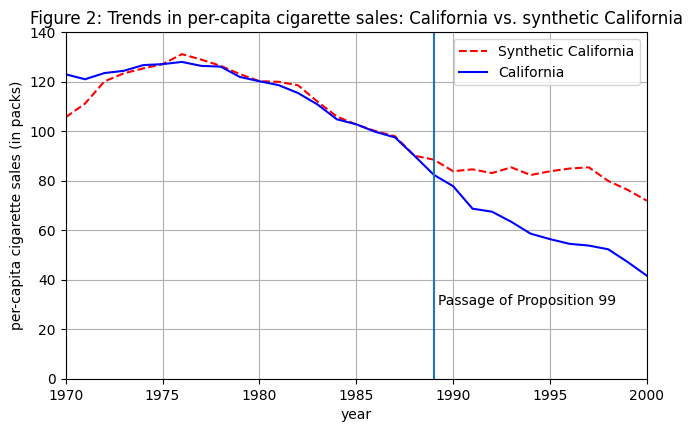

In [33]:
# Calculating synthetic control outcomes.
SC_outcomes = np.vstack([Z0, Y0]).dot(W)

# Calculating California outcomes.
CA_outcomes = np.vstack([Z1, Y1]).flatten()

# Plotting trends of SC and California.
fig = plt.figure(figsize=(7.5,4.5))

plt.plot(range(START_TIME,STOP_TIME),SC_outcomes, 'r--', label="Synthetic California");
plt.plot(range(START_TIME,STOP_TIME),CA_outcomes, 'b-', label="California");

plt.ylabel('per-capita cigarette sales (in packs)')
plt.xlabel('year')
plt.legend(loc='upper right')
plt.title("Figure 2: Trends in per-capita cigarette sales: California vs. synthetic California")
plt.axvline(INTERVENTION_TIME)
plt.text(x=INTERVENTION_TIME+0.2, y=30, s='Passage of Proposition 99')
plt.xlim([START_TIME, STOP_TIME-1])
plt.ylim([0, 140])
plt.grid()
plt.show()
fig.savefig("prop99_figure2", dpi=300)

Making table of mean cigarette sales for California, synthetic control, and all states.

In [34]:
mean_predictors = X0.mean(axis=1)
print("Table 1: Cigarette sales predictor means \n")
display(pd.DataFrame(np.hstack([X1, X0.dot(W).reshape(-1,1), mean_predictors.reshape(-1,1)]),
             columns=['Real California', 'Synthetic California', 'Average of 38 Controls']))

Table 1: Cigarette sales predictor means 



,Real California,Synthetic California,Average of 38 Controls
0,10.076559,10.076559,10.076559
1,17.353238,17.353238,17.353238
2,89.422223,89.422223,89.422223
3,24.280000,24.280000,24.280000
4,90.100000,90.099949,113.823684
5,120.200000,120.200015,138.089474
6,127.100000,127.100224,136.931579


List of states with top 5 weights.

In [35]:
list(df_outcome['LocationDesc'].values[1+np.flip(W.argsort())][:5])

['Utah', 'North Carolina', 'North Dakota', 'Montana', 'New Hampshire']

Calculating and plotting the gap in cigarette sales between California and synthetic California.

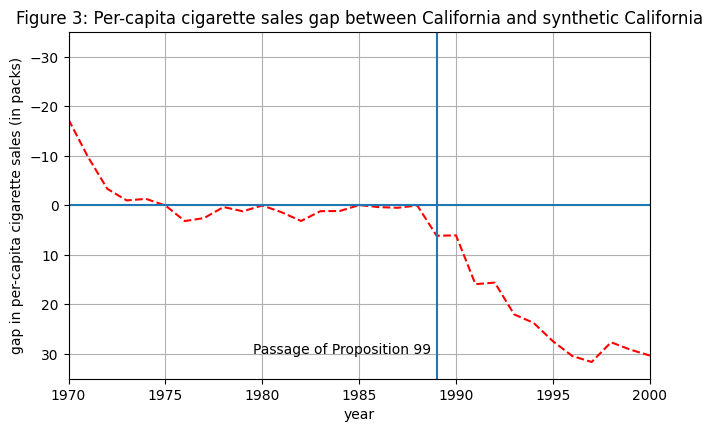

In [36]:
Gap_outcome = np.vstack([Z0, Y0]).dot(W) - np.vstack([Z1, Y1]).flatten()
fig = plt.figure(figsize=(7.5,4.5))

plt.plot(range(START_TIME,STOP_TIME),Gap_outcome, 'r--');
plt.ylabel('gap in per-capita cigarette sales (in packs)')
plt.xlabel('year')
plt.title("Figure 3: Per-capita cigarette sales gap between California and synthetic California")
plt.axhline(0)
plt.axvline(INTERVENTION_TIME)
plt.text(x=INTERVENTION_TIME-9.5, y=30, s='Passage of Proposition 99')
plt.xlim([START_TIME, STOP_TIME-1])
plt.ylim([35, -35])
plt.grid()
plt.show()
fig.savefig("prop99_figure3", dpi=300)